In [27]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import datetime
import random
import math

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Quandl
import numpy as np
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.grid_search import GridSearchCV

import utils as ut
from utils import RET_PER, FIG_WIDTH, FIG_HEIGHT, TARGET_SERIES, TARGET_INDICATOR

sns.set_context("paper")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
tar = ut.load_target()
PANEL_SCORE = True

## increasing values

In [3]:
series = 'IV'
px, px_ca, px_us = ut.load_series(series)

int: 6.18220627203e-16	coef: 0.543239747314


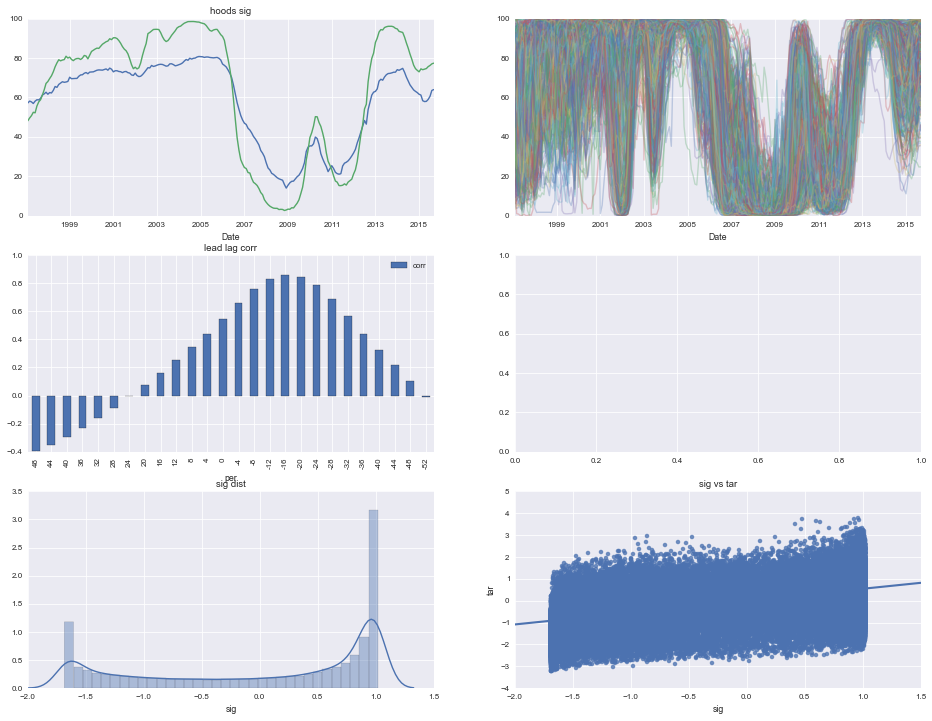

In [146]:
ut.explore_series(px, px_ca, px_us, tar)

## decreasing values

In [31]:
series = 'DV'
px, px_ca, px_us = ut.load_series(series)

int: -9.72514953918e-15	coef: -0.539402120121


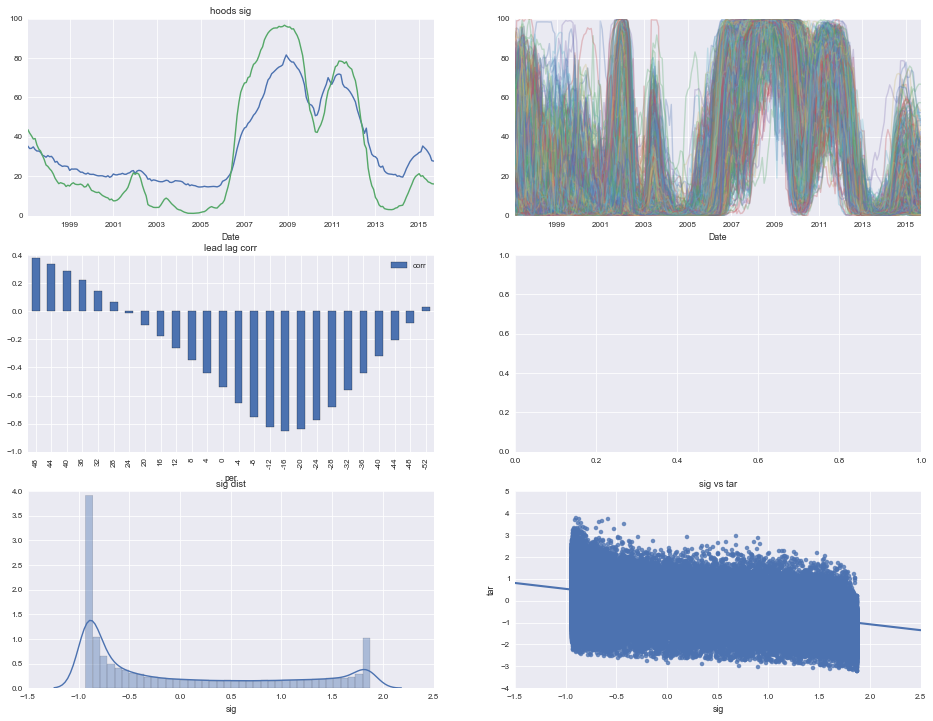

In [32]:
ut.explore_series(px, px_ca, px_us, tar)

## ratio sales price to list price

In [33]:
series = 'SLPR'
px, px_ca, px_us = ut.load_series(series)

In [34]:
px

,00003,00004,00007,00014,00021,00025,00032,00034,00035,00037,...,01028,01145,01213,01535,01987,02046,02637,04463,04531,05903
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-28,0.9954,0.99,0.9937,0.9801,0.9857,0.9987,0.9783,0.9757,0.9872,1.0667,...,0.9734,0.9812,1,0.9747,0.9699,0.9608,0.993141,1.0821,0.9697,0.9956


## turnover in housing market in past year

In [35]:
series = 'SPY'
px, px_ca, px_us = ut.load_series(series)

int: -4.63035810897e-15	coef: 0.12150467813


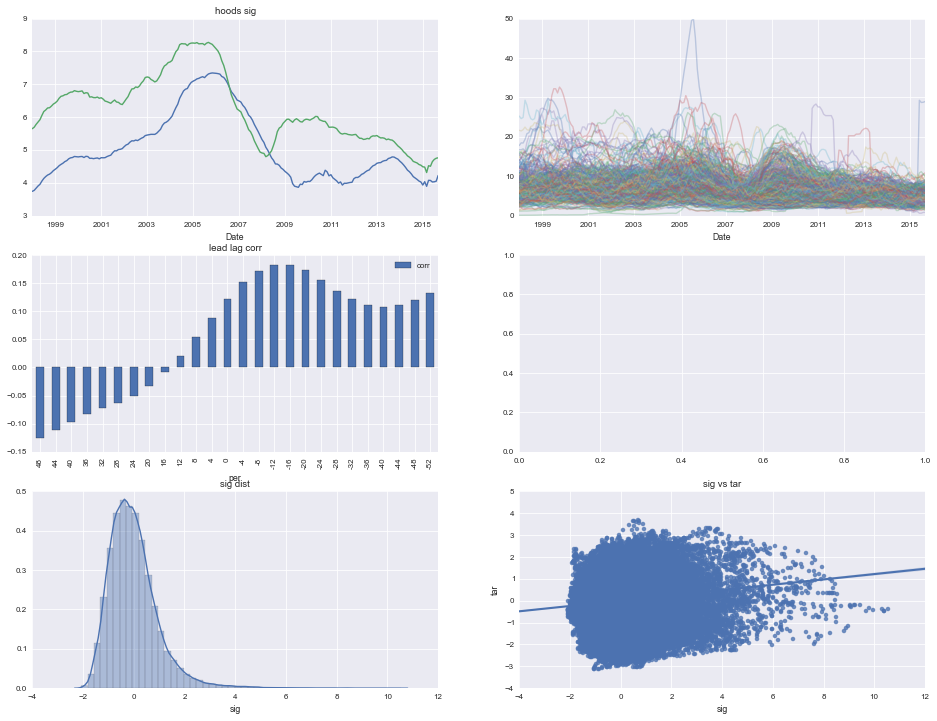

In [36]:
ut.explore_series(px, px_ca, px_us, tar)

## sold for gain

In [73]:
series = 'SFG'
px, px_ca, px_us = ut.load_series(series)

In [74]:
yoy = lambda x: x / x.shift(24) - 1.
px, px_ca, px_us = ut.capped_transformation(yoy, px, px_ca, px_us)
SFG_c = px

int: 6.38208537954e-15	coef: 0.220998714584


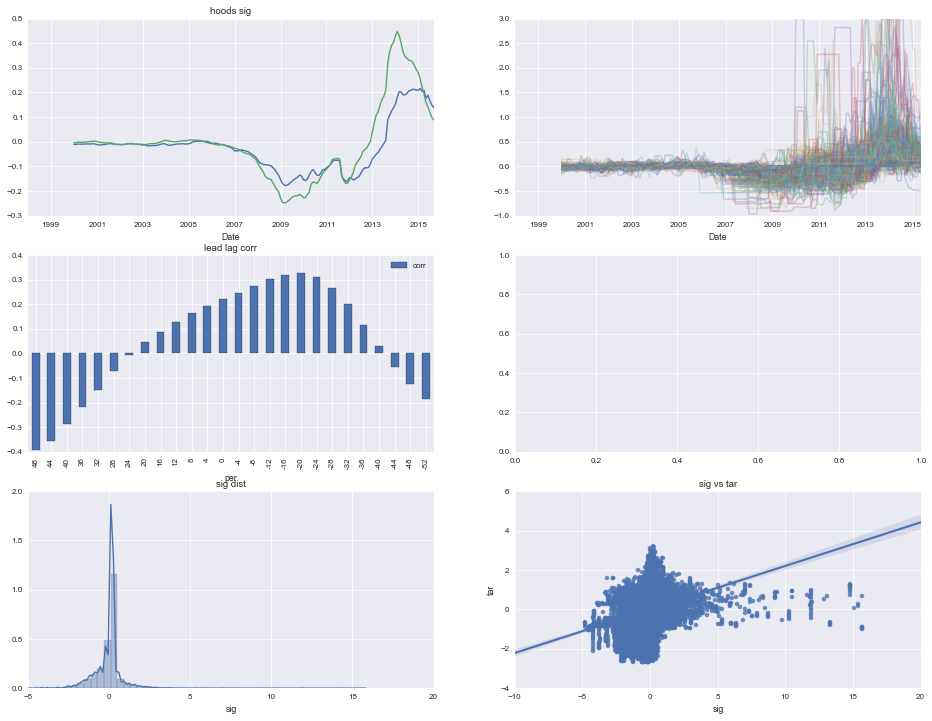

In [75]:
ut.explore_series(px, px_ca, px_us, tar)

# price per square foot

In [40]:
series = 'MVSF'
px, px_ca, px_us = ut.load_series(series)

In [41]:
px, px_ca, px_us = ut.capped_transformation(yoy, px, px_ca, px_us)
MVSF_c = px

int: -2.85943207518e-14	coef: 0.488553051962


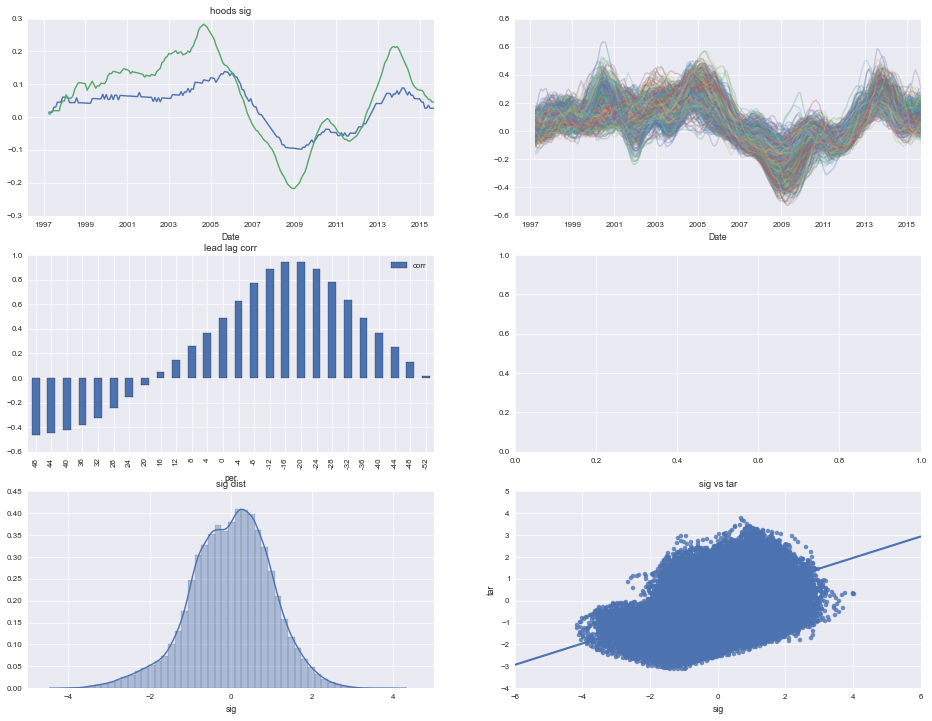

In [22]:
ut.explore_series(px, px_ca, px_us, tar)

# momentum

In [42]:
px, px_ca, px_us = ut.load_series(TARGET_SERIES)

In [43]:
px, px_ca, px_us = ut.capped_transformation(ut.momentum, px, px_ca, px_us)
TAR_mom = px

int: -2.08862042335e-14	coef: 0.329269714338


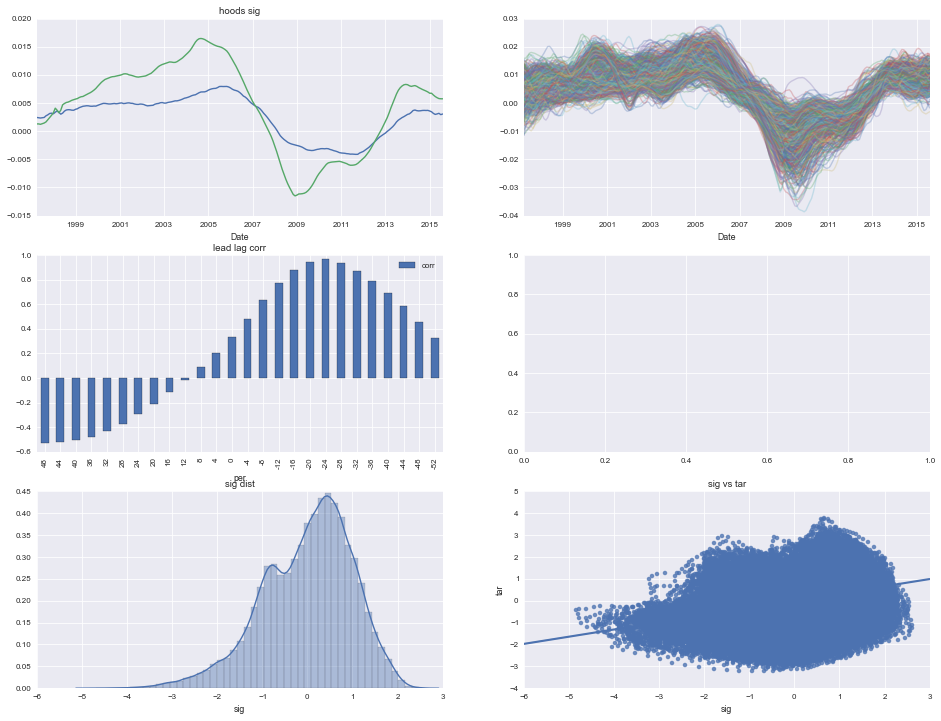

In [19]:
ut.explore_series(px, px_ca, px_us, tar)

# change in momentum

In [44]:
px, px_ca, px_us = ut.load_series(TARGET_SERIES)

In [45]:
def momentum_change(df):
        mom_cur = ut.momentum(df)
        mom_prev = ut.momentum(df.shift(12))
        return (mom_cur - mom_prev).dropna(how='all')

In [46]:
px, px_ca, px_us = ut.capped_transformation(momentum_change, px, px_ca, px_us)
TAR_mom_chg = px

int: -8.61038192251e-15	coef: 0.548548622923


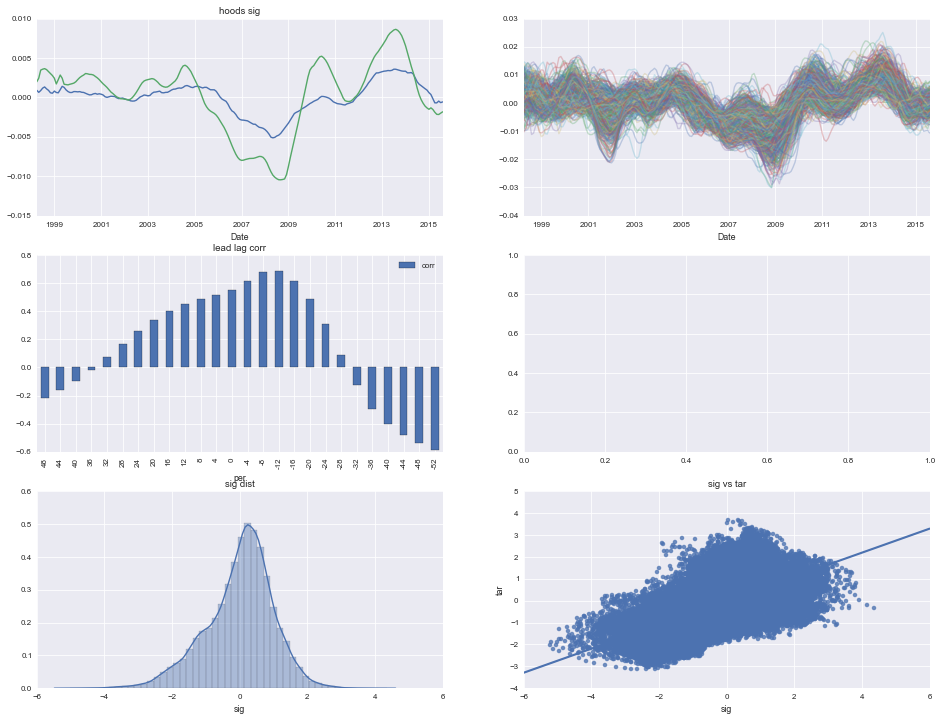

In [34]:
ut.explore_series(px, px_ca, px_us, tar)

## build model

In [133]:
features = {}
for i in ('IV', 'DV', 'SPY'):
    features[i] = ut.load_quandl_data('hoods', i)
features['tar'] = tar
features['SFG'] = SFG_c
features['MVSF'] = MVSF_c
features['TAR_mom'] = TAR_mom
features['TAR_mom_chg'] = TAR_mom_chg

df = ut.stack_and_align(features.values(), cols=features.keys()).dropna()

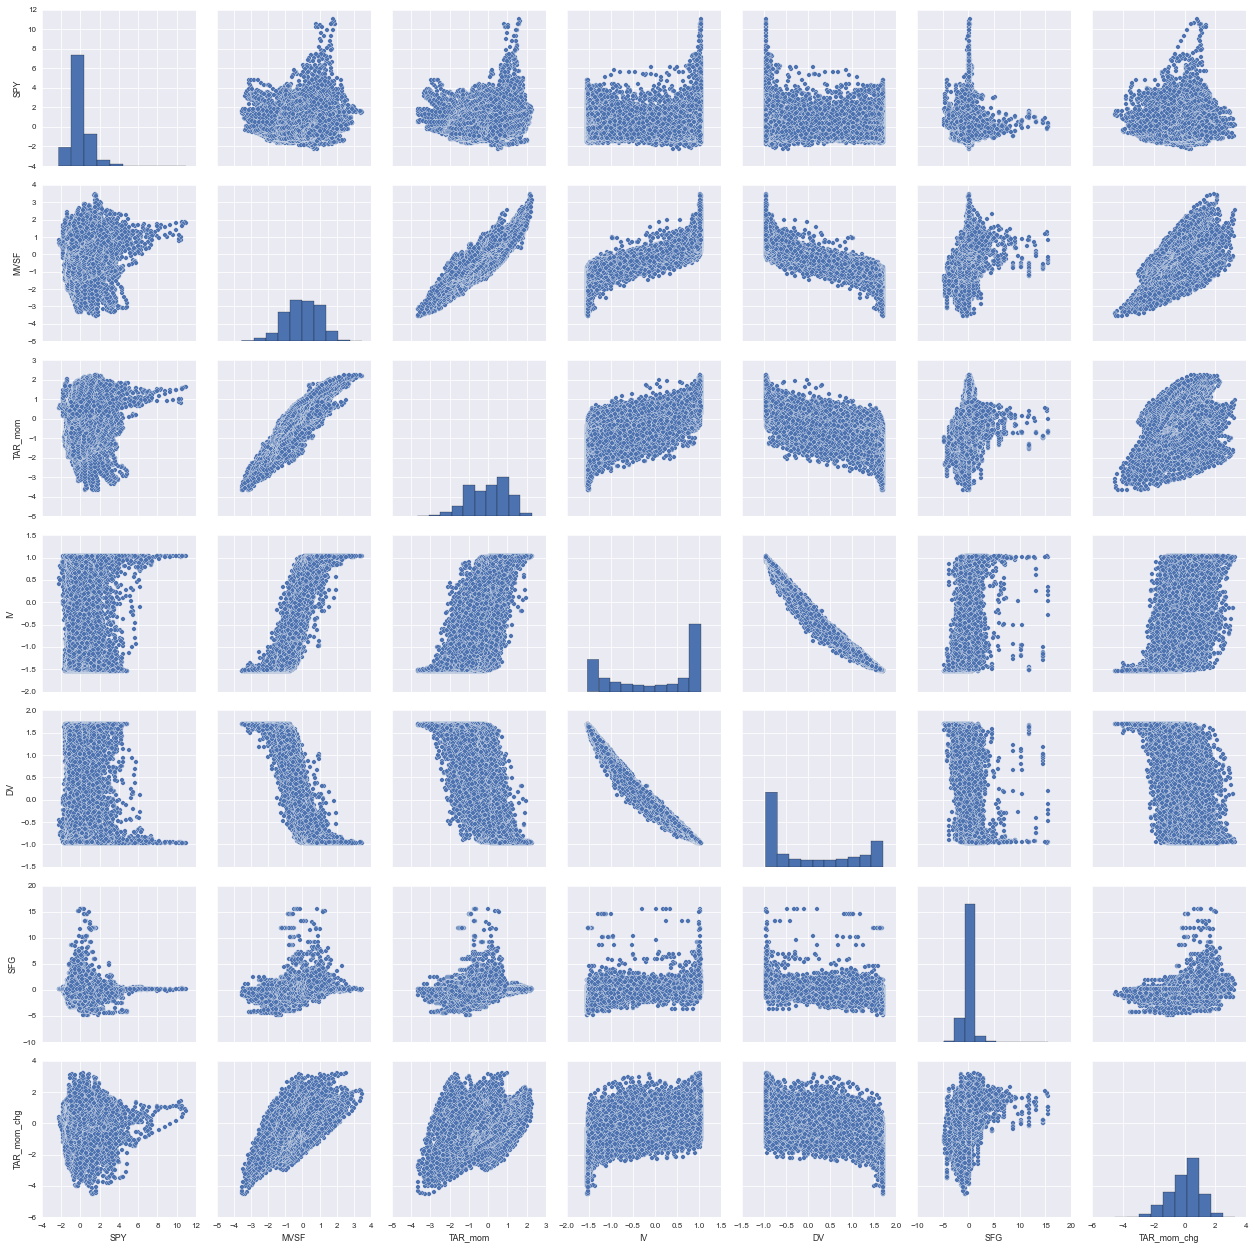

In [134]:
sns.pairplot(ut.ts_score(df[[c for c in df.columns if c != 'tar']], panel=PANEL_SCORE))

sharpe ratios:
0.2    1.006290
0.4    1.609560
0.6    2.027115
0.8    2.297885
1.0    2.281202
mkt    1.639003
dtype: float64

r2: 0.340426529436	int: 6.88149251435e-15	coef: [-0.00394749  0.0834721   0.02090553  0.10393184 -0.09736188  0.02889608
  0.15743199]	alpha: 50000


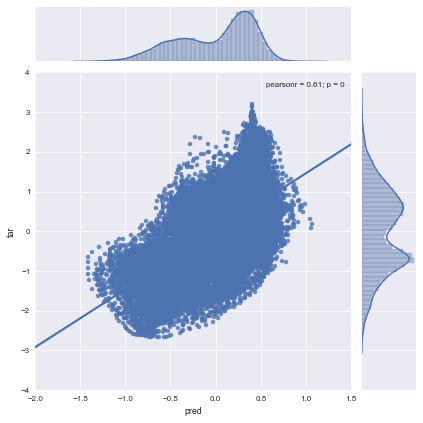

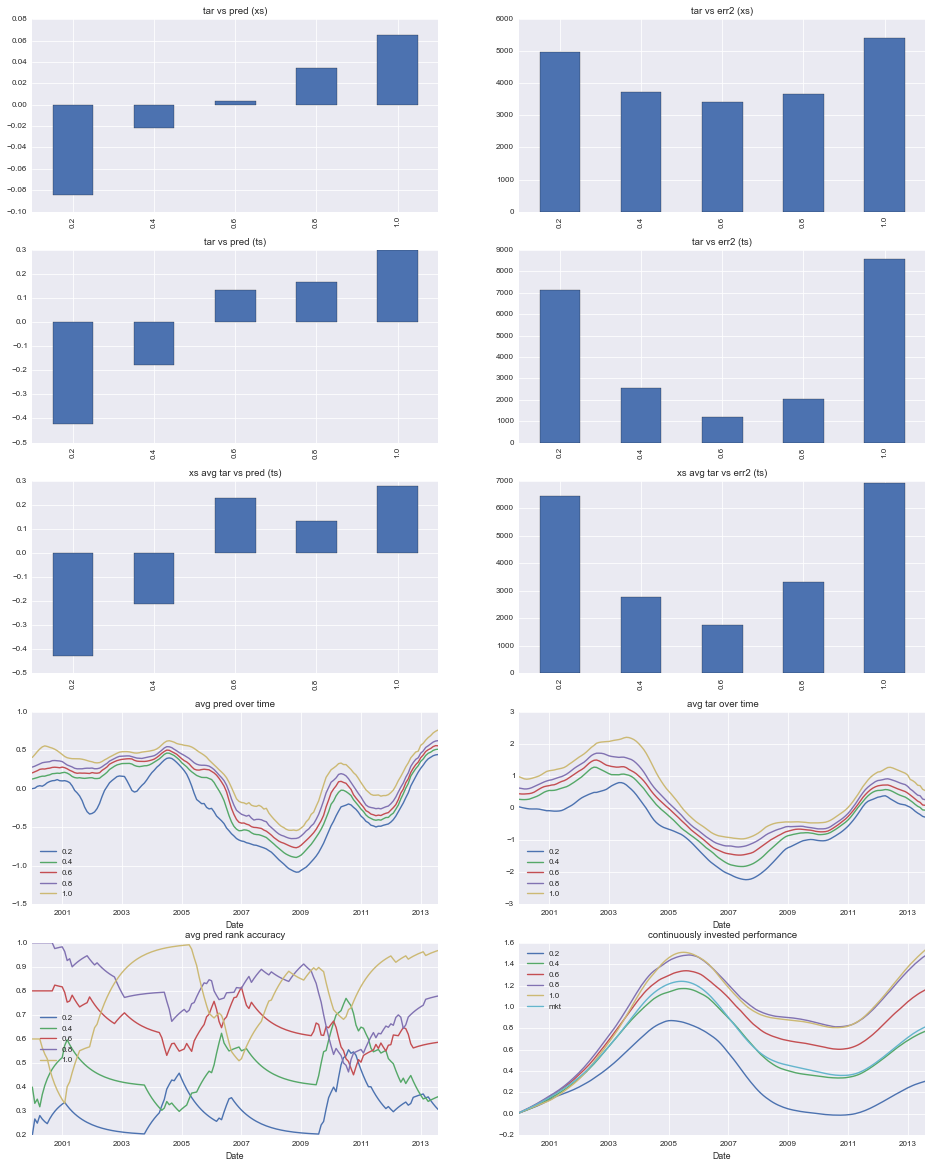

In [141]:
clf = lm.RidgeCV(alphas=[1., 10., 100, 1000, 10000, 50000, 10000000], cv=5)
clf, df_res, score = ut.build_model(clf, df, PANEL_SCORE)
print
print('r2: {2}\tint: {0}\tcoef: {1}\talpha: {3}'.format(clf.intercept_, clf.coef_, score, clf.alpha_))

sharpe ratios:
0.2    0.958072
0.4    1.578525
0.6    2.029079
0.8    2.301360
1.0    2.362357
mkt    1.639003
dtype: float64

r2: 0.395033863998	int: 6.57909415573e-15	coef: [-0.          0.          0.          0.25644368 -0.          0.
  0.33271365]	alpha: 0.1


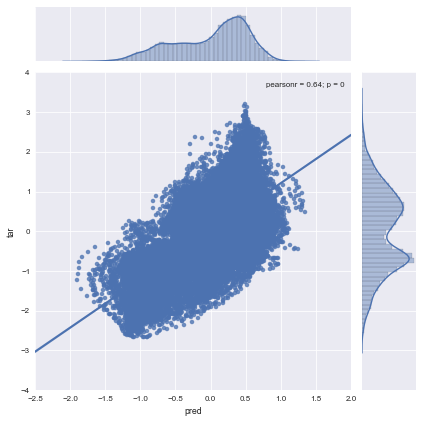

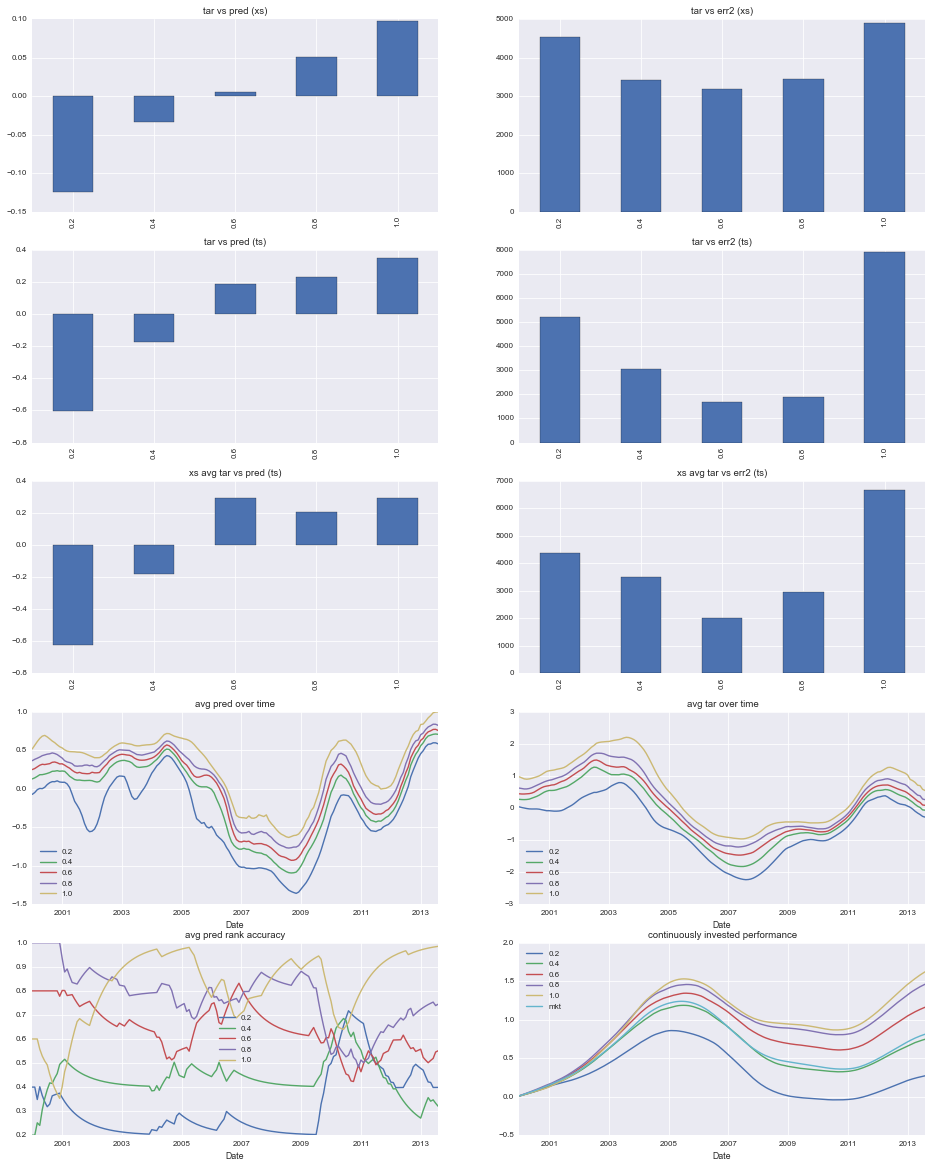

In [140]:
clf = lm.LassoCV(alphas=[.0001, .001, .01, .1], cv=5)
clf, df_res, score = ut.build_model(clf, df, PANEL_SCORE)
print
print('r2: {2}\tint: {0}\tcoef: {1}\talpha: {3}'.format(clf.intercept_, clf.coef_, score, clf.alpha_))

sharpe ratios:
0.2    2.634558
0.4    2.218516
0.6   -1.477199
0.8   -4.123128
1.0   -5.753172
mkt    1.405244
dtype: float64

r2: 0.47240922603
DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=2,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best')


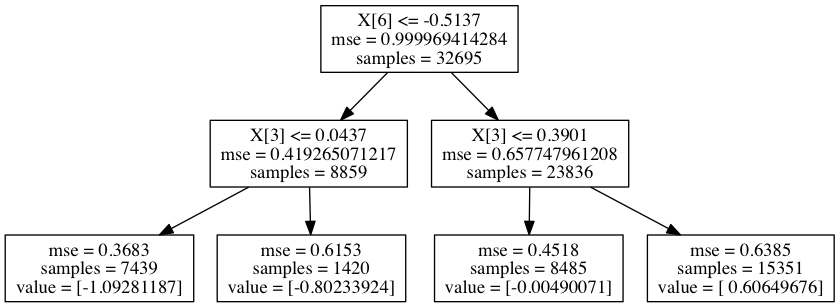

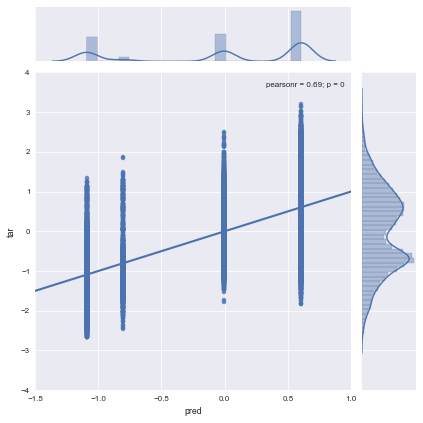

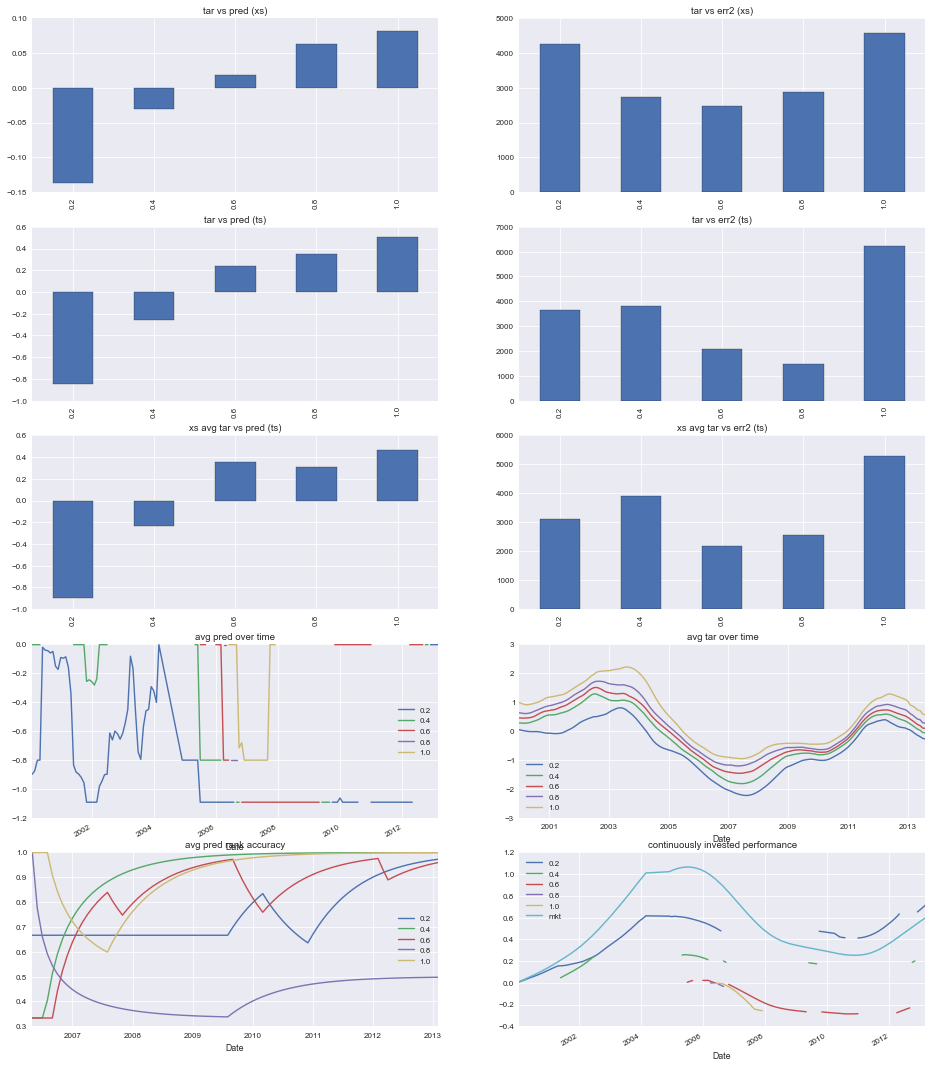

In [144]:
clf = GridSearchCV(tree.DecisionTreeRegressor(), param_grid={'max_depth': [2,3,5], 'max_features': [None, 1, 2]}, cv=5)
clf, df_res, score = ut.build_model(clf, df, PANEL_SCORE)
print
print('r2: {0}'.format(score,))
print clf.best_estimator_
ut.tree_vis(clf.best_estimator_)

# why does this score show differently based on whether preds are ts scored?

sharpe ratios:
0.2    1.042415
0.4    1.654439
0.6    1.949437
0.8    2.240493
1.0    2.317107
mkt    1.639003
dtype: float64

r2: 0.470410357694


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=1, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

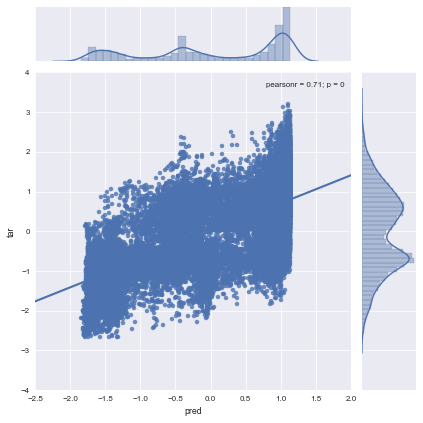

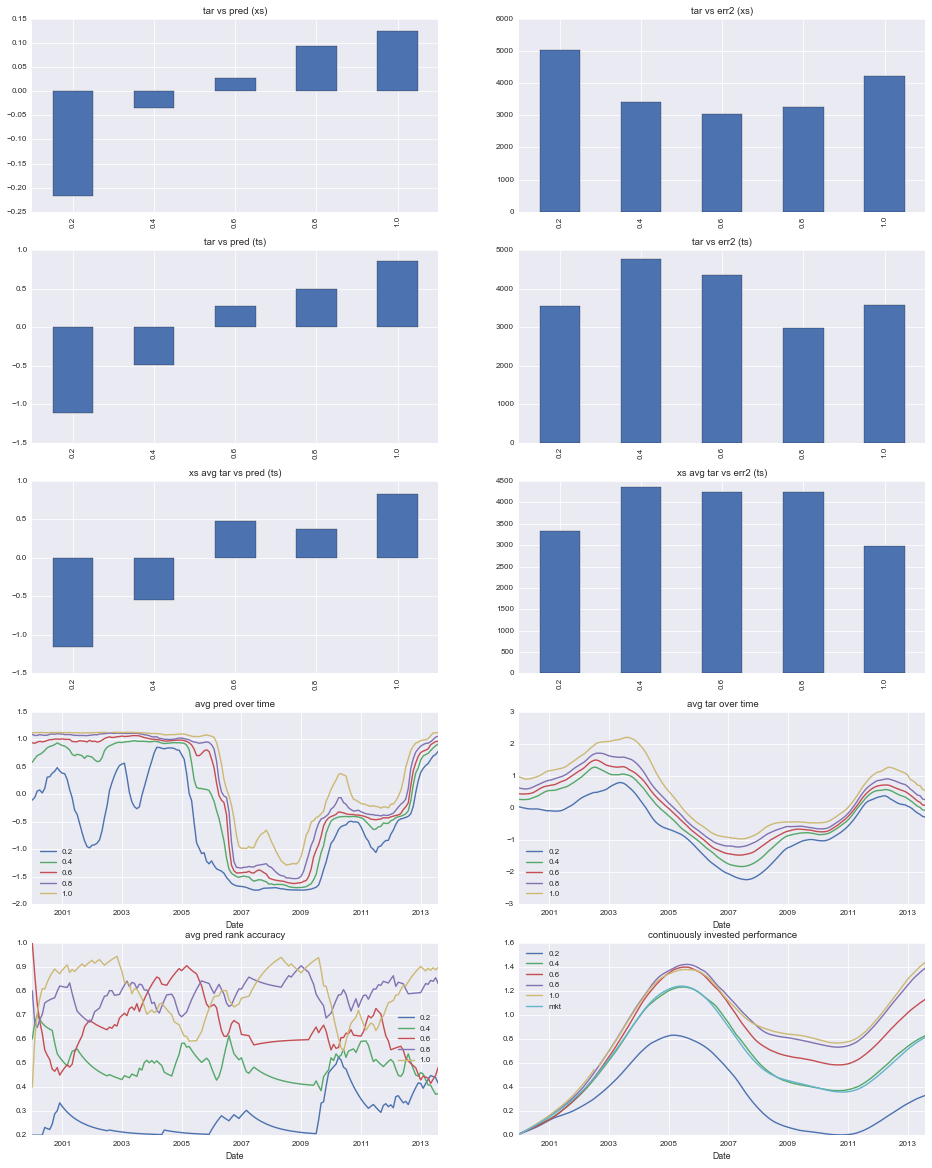

In [151]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=100), param_grid={'max_depth': [2,3,5,7], 'max_features': [None, 1, 2, 4]}, cv=5, n_jobs=1)
clf, df_res, score = ut.build_model(clf, df, PANEL_SCORE)
print
print('r2: {0}'.format(score,))
clf.best_estimator_

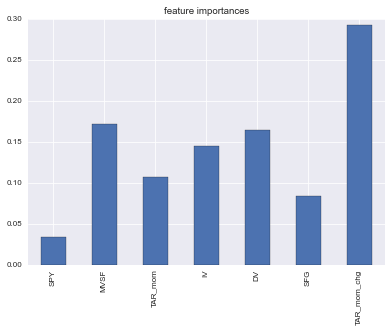

In [152]:
(pd.Series(clf.best_estimator_.feature_importances_, index=[c for c in df.columns if c != 'tar'])
 .plot(kind='bar', title='feature importances'))

sharpe ratios:
0.2    1.171139
0.4    1.713285
0.6    2.077604
0.8    1.966568
1.0    1.916179
mkt    1.639003
dtype: float64

r2: 0.488636749473


GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=1, max_features=2, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

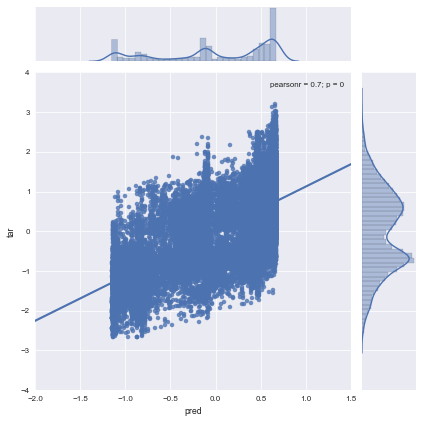

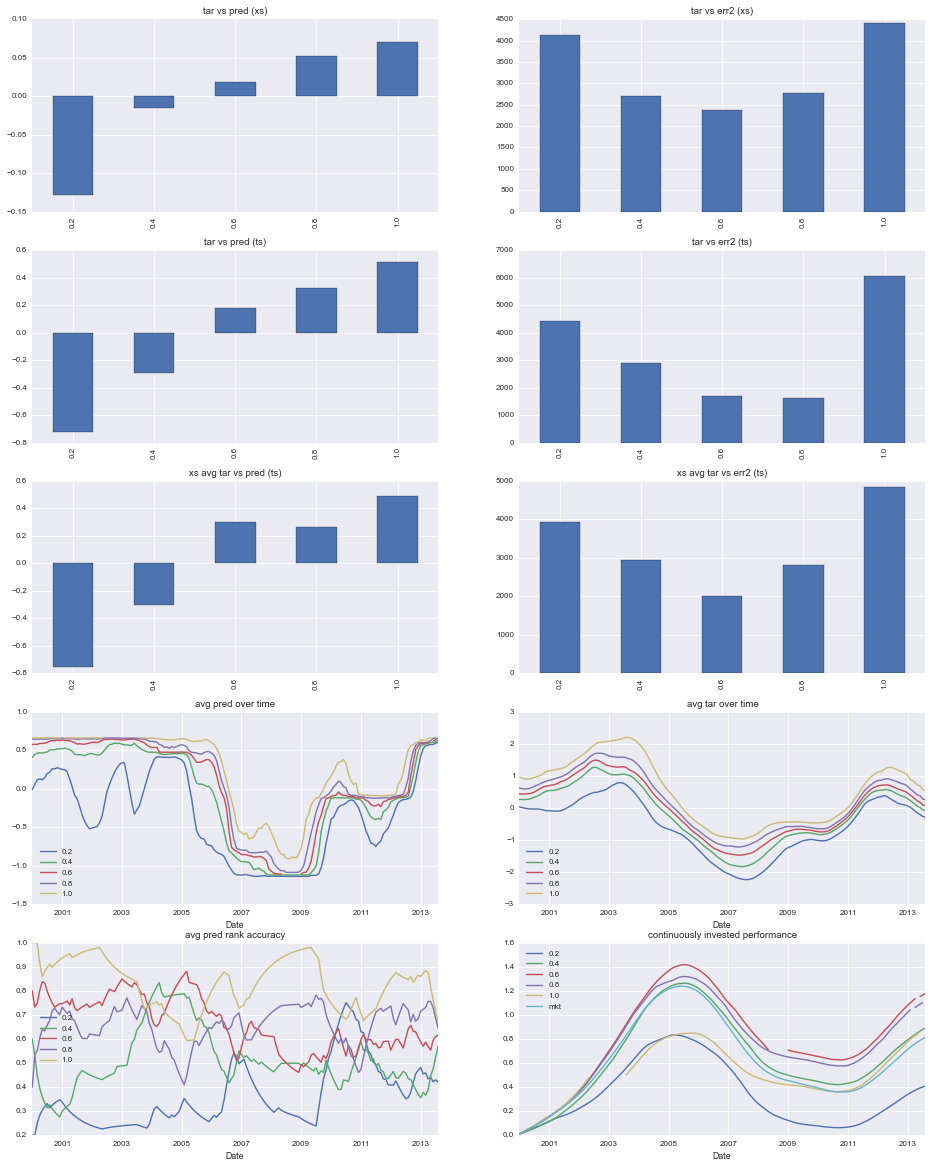

In [147]:
clf = GridSearchCV(GradientBoostingRegressor(), param_grid={'n_estimators': [50, 200],
                                                            'max_depth': [1,3,5], 
                                                            'max_features': [None, 1, 2]}, 
                   cv=5, n_jobs=2)
clf, df_res, score = ut.build_model(clf, df, PANEL_SCORE)
print
print('r2: {0}'.format(score,))
clf.best_estimator_

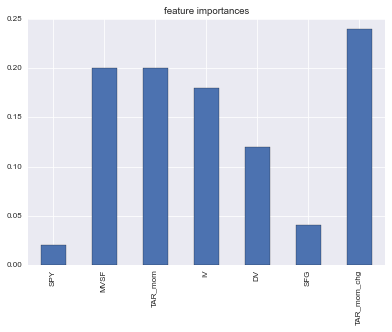

In [148]:
(pd.Series(clf.best_estimator_.feature_importances_, index=[c for c in df.columns if c != 'tar'])
 .plot(kind='bar', title='feature importances'))